# Evaluating a Data Model

In this lab you partition a dataset into two datasets, a training dataset and a test dataset. You use the training dataset to develop a model. You use the test dataset to evaluate the accuracy of the model, and then to evaluate predictive models in a repeatable manner.

After you use the training set to create a model, you evaluate the model against the test dataset. You store the data in BigQuery, and use Jupyterlab to perform the analysis.

This lab uses a dataset provided by [US Bureau of Transport Statistics](https://www.bts.gov/). The dataset provides historic information about internal flights in the United States and can be used to demonstrate a wide range of data science concepts and techniques.

BigQuery is a RESTful web service that enables interactive analysis of massive datasets. BigQuery works in conjunction with Google Storage. See BigQuery for more information.

## Objectives

* Partition a BigQuery dataset into a training dataset and a test dataset.
* Create a predictive model using the training dataset.
* Evaluate the predictive model using the test dataset.

This notebook is based on a hands-on lab on Qwiklabs. The link to the lab can be found at [here](https://www.cloudskillsboost.google/focuses/1163?parent=catalog).

# Task 1: Prepare Your Environment

This lab uses a set of code samples and scripts developed for [Data Science on the Google Cloud Platform, 2nd Edition](https://www.oreilly.com/library/view/data-science-on/9781098118945/) from O'Reilly Media, Inc. For this lab, you clone the sample repository from Github to Cloud Shell and carry out all of the lab tasks from there.

## Selecting A Training Data Set

Before selecting your training dataset, you must decide on a repeatable mechanism to select a subset of the data as the training dataset, which you use to create predictive models. You use the remaining data in the dataset as the test set, which you use to evaluate the effectiveness of your models.

You also need to provide a representative selection of the data. Possible options:

* Add a `WHERE` clause to select records using BigQuery's `RAND()` function. Unfortunately that makes it virtually impossible to select an independent evaluation test dataset. Also, the `RAND()` function returns different results every time it's run, which makes it impossible to compare model performance between different runs.
* Select a specific date range, or just the first N records in the table. Unfortunately, you could inadvertently select training data that omits on some date-based variation in the data.
* Identify a specific set of dates, each of which is initially chosen at random, as the training dataset. The dates are saved in a separate database table. This allows you to carry out multiple replays of training and test queries in a consistent manner. This is the **best approach**.

To identify all of the unique dates in the dataset:

```sql
SELECT DISTINCT(FL_DATE) AS FL_DATE FROM `dsongcp.flights_tzcorr` ORDER BY FL_DATE
```

The result:

![](https://media.discordapp.net/attachments/984655726406402088/993080674162589696/unknown.png)

To randomly select 70% of these dates to be the training days:

```sql
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (SELECT DISTINCT(FL_DATE) AS FL_DATE FROM dsongcp.flights_tzcorr) ORDER BY FL_DATE
LIMIT 5
```

The result:

![](https://media.discordapp.net/attachments/984655726406402088/993080738725498910/unknown.png)

In the preceding query, the hash value of each of the unique days from the inner query is computed using the [FarmHash](https://opensource.googleblog.com/2014/03/introducing-farmhash.html) library. The `is_train_day` field is set to True if the last two digits of this hash value are less than 70.

To save query result as a table:

```sql
CREATE OR REPLACE TABLE dsongcp.trainday AS
SELECT
  FL_DATE,
  IF(ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
     'True', 'False') AS is_train_day
FROM (SELECT DISTINCT(FL_DATE) AS FL_DATE FROM dsongcp.flights_tzcorr) ORDER BY FL_DATE
```

# Task 2: Create The Model Using The Training Data Set

## Import Modules

Import the necessary modules and initialize a BigQuery client. The BigQuery client sends and receives messages from the BigQuery API.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.cloud import bigquery as bq

Create a variable with the new BigQuery query using just the training day partition of the dataset:

In [2]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM dsongcp.flights_tzcorr
JOIN dsongcp.trainday USING(FL_DATE) WHERE is_train_day = 'True'
GROUP BY DEP_DELAY HAVING numflights > 370 ORDER BY DEP_DELAY

Downloading: 100%|██████████| 224/224 [00:02<00:00, 103.47rows/s]


Plot the intersection of the 15 minute delay line with the 30% arrival delay probability line for the training dataset:

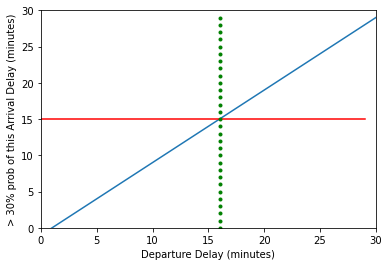

In [3]:
ax = plt.axes()

depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay', ax=ax, ylim=(0, 30), xlim=(0, 30), legend=False)

ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% prob of this Arrival Delay (minutes)')

x = np.arange(0, 30)
y = np.ones_like(x) * 15

ax.plot(x, y, color='r')

y = np.arange(0, 30)
x = np.ones_like(y) * 16

ax.plot(x, y, 'g.')

Notice you get the same answer—16 minutes—after creating the empirical probabilistic model on just the training data. This is good.

In the next secion, you test this model against the independent test data set.

# Task 3. Evaluate the data model

Evaluate how well your recommendation of 16 minutes does in terms of predicting an arrival delay of 15 minutes or more. To do that, find the number of times you would have wrongly canceled a meeting or missed a meeting. Compute these numbers using query on days that are not training days to compute these numbers:

In [4]:
%%bigquery df_eval
SELECT
    SUM(IF(DEP_DELAY < 16 AND arr_delay < 15, 1, 0)) AS correct_nocancel,
    SUM(IF(DEP_DELAY < 16 AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
    SUM(IF(DEP_DELAY >= 16 AND arr_delay < 15, 1, 0)) AS wrong_cancel,
    SUM(IF(DEP_DELAY >= 16 AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM ( 
    SELECT DEP_DELAY, ARR_DELAY FROM dsongcp.flights_tzcorr
    JOIN dsongcp.trainday USING(FL_DATE) WHERE is_train_day = 'False' 
)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.21s/rows]


In [5]:
print(df_eval['correct_nocancel'] / (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

0    0.950158
dtype: float64
0    0.804703
dtype: float64


In [6]:
df_eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1259740,66081,52827,217669


Note that this query does not exclude the outlier data. You are evaluating real data against the model to see how well it performs in all situations.

Now, we will create a query string that captures the contingency table that allows you to score the effectiveness of the model:

In [7]:
%%bigquery df_eval
SELECT
    SUM(IF(DEP_DELAY = 15 AND arr_delay < 15, 1, 0)) AS correct_nocancel,
    SUM(IF(DEP_DELAY = 15 AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
    SUM(IF(DEP_DELAY = 16 AND arr_delay < 15, 1, 0)) AS wrong_cancel,
    SUM(IF(DEP_DELAY = 16 AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
    SELECT DEP_DELAY, ARR_DELAY FROM dsongcp.flights_tzcorr
    JOIN dsongcp.trainday USING(FL_DATE) WHERE is_train_day = 'False' 
)

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.16s/rows]


In [8]:
df_eval.head()

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,7684,2935,6787,2942


Display the ratio of correct to incorrect calls for the full evaluation dataset:

In [9]:
print(df_eval['correct_nocancel'] / (df_eval['correct_nocancel'] + df_eval['wrong_nocancel']))
print(df_eval['correct_cancel'] / (df_eval['correct_cancel'] + df_eval['wrong_cancel']))

0    0.723609
dtype: float64
0    0.302395
dtype: float64


As expected, you are correct to not cancel the meeting 72% of the time, close to our target of 70%. You chose the departure delay threshold of 16 minutes on the training dataset because you expected to be 70% correct in not canceling if you do so, you now proved on an independent dataset that this is the case.

This model achieves the 70% correctness measure that was our target but does so by canceling fewer flights than the contingency-table-based model of Chapter 3.